# Week 5 – GANs Project: Monet Style Transfer Using CycleGAN

#### DTSA 5511 Introduction to Deep Learning, Week 5

&nbsp;

<b>Instructions</b>: <i>We will use this Kaggle competition to practice building and training generative deep learning models (mostly GAN). Kaggle introduces an evaluation metric called MiFID (Memorization-informed Fréchet Inception Distance) score to evaluate the quality of generated images.</i>

First, I'll import the libraries I need for this project

In [ ]:
# Import standard Python libraries
import os         # For file and directory operations
import random     # For random number generation (e.g., shuffling, sampling)
import time       # For tracking training time or delays

# Import NumPy for numerical operations
import numpy as np

# Import TensorFlow and key modules
import tensorflow as tf
from tensorflow.keras import layers, models, losses, optimizers  # Core Keras components

# Import matplotlib for plotting images and graphs
import matplotlib.pyplot as plt

# Import Kaggle's dataset API to access datasets in the competition environment
from kaggle_datasets import KaggleDatasets

2025-04-22 15:55:06.642210: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745337306.888587      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745337306.962907      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Brief description of the problem and data

In this challenge, the goal is to build a Generative Adversarial Network (GAN) that can transfer the style of Monet paintings to photographs of landscapes. Style transfer is a task where GANs perform exceptionally well because they are designed to preserve the content of the original image while applying stylistic features learned from a different domain.

Generative deep learning models differ from traditional models in that they don’t make predictions like classifications or regressions. Instead, they aim to generate new data that resembles the training distribution. A GAN consists of two networks:

The generator, which creates new images

The discriminator, which attempts to distinguish between real images and those generated by the generator

Through this adversarial training process, the generator gradually improves its ability to produce realistic, Monet-style paintings from ordinary landscape photos.

Let's take a look at the size and shape of the data. How many images are in both datasets?

In [ ]:
# Define a function to count the total number of examples in TFRecord files
def count_tfrecord_examples(tfrecord_dir):
    # Get a list of all .tfrec files in the given directory
    tfrecord_files = tf.io.gfile.glob(os.path.join(tfrecord_dir, '*.tfrec'))
    
    total = 0  # Initialize a counter for the total number of images

    # Iterate over each TFRecord file
    for tfrec in tfrecord_files:
        # Create a TFRecordDataset to read serialized examples
        dataset = tf.data.TFRecordDataset(tfrec)

        # Count the number of examples in this TFRecord file
        count = sum(1 for _ in dataset)

        # Print the count for the current file
        print(f"{tfrec}: {count} images")

        # Add to the total count
        total += count

    # Return the total number of images across all TFRecord files
    return total

In [3]:
# Count for Monet
monet_count = count_tfrecord_examples("/kaggle/input/gan-getting-started/monet_tfrec/")
print(f"\nTotal Monet images: {monet_count}")

2025-04-22 15:55:20.931075: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


/kaggle/input/gan-getting-started/monet_tfrec/monet12-60.tfrec: 60 images
/kaggle/input/gan-getting-started/monet_tfrec/monet16-60.tfrec: 60 images
/kaggle/input/gan-getting-started/monet_tfrec/monet08-60.tfrec: 60 images
/kaggle/input/gan-getting-started/monet_tfrec/monet04-60.tfrec: 60 images
/kaggle/input/gan-getting-started/monet_tfrec/monet00-60.tfrec: 60 images

Total Monet images: 300


In [4]:
# Count for Photo
photo_count = count_tfrecord_examples("/kaggle/input/gan-getting-started/photo_tfrec/")
print(f"\nTotal Photo images: {photo_count}")

/kaggle/input/gan-getting-started/photo_tfrec/photo12-352.tfrec: 352 images
/kaggle/input/gan-getting-started/photo_tfrec/photo11-352.tfrec: 352 images
/kaggle/input/gan-getting-started/photo_tfrec/photo05-352.tfrec: 352 images
/kaggle/input/gan-getting-started/photo_tfrec/photo08-352.tfrec: 352 images
/kaggle/input/gan-getting-started/photo_tfrec/photo18-352.tfrec: 352 images
/kaggle/input/gan-getting-started/photo_tfrec/photo06-352.tfrec: 352 images
/kaggle/input/gan-getting-started/photo_tfrec/photo17-352.tfrec: 352 images
/kaggle/input/gan-getting-started/photo_tfrec/photo10-352.tfrec: 352 images
/kaggle/input/gan-getting-started/photo_tfrec/photo09-352.tfrec: 352 images
/kaggle/input/gan-getting-started/photo_tfrec/photo15-352.tfrec: 352 images
/kaggle/input/gan-getting-started/photo_tfrec/photo04-352.tfrec: 352 images
/kaggle/input/gan-getting-started/photo_tfrec/photo19-350.tfrec: 350 images
/kaggle/input/gan-getting-started/photo_tfrec/photo02-352.tfrec: 352 images
/kaggle/inpu

Ok, we have 300 images of Monet paintings to work with, and 7,038 landscape photos as well.

What size are the photos?

In [5]:
# Choose a random tfrecord file
directory = "/kaggle/input/gan-getting-started/photo_tfrec/"
tfrecord_files = tf.io.gfile.glob(os.path.join(directory, '*.tfrec'))
random_file = random.choice(tfrecord_files)

# Open up the tfrecord file
raw_dataset = tf.data.TFRecordDataset(random_file)

# Function to unpack images from the opened tfrecord file
def parse_image(record):
    feature_description = {'image': tf.io.FixedLenFeature([], tf.string)}
    parsed = tf.io.parse_single_example(record, feature_description)
    image = tf.io.decode_jpeg(parsed['image'], channels=3)
    image = tf.image.resize(image, [256, 256])
    image = tf.cast(image, tf.float32) / 255.0  # [0, 1] range for display
    return image

# Parse the dataset
parsed_dataset = raw_dataset.map(parse_image)

# Display the image
image = next(iter(parsed_dataset.take(1)))
print("Image shape:", image.shape)

Image shape: (256, 256, 3)


The images are 256 by 256 pixels, and each pixel has three channels: R, G, and B. This is standard for image data.

We now have some understanding of the data files that have been provided, and what their dimensions are. In the next section, we take a closer look at the data itself.

### Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

First, let's see what some of these images look like:

In [6]:
def random_image_from_tfrecord(directory):
    # Choose a random tfrecord file
    tfrecord_files = tf.io.gfile.glob(os.path.join(directory, '*.tfrec'))
    random_file = random.choice(tfrecord_files)
    
    # Open up the tfrecord file
    raw_dataset = tf.data.TFRecordDataset(random_file)
    
    # Function to unpack images from the opened tfrecord file
    def parse_image(record):
        feature_description = {'image': tf.io.FixedLenFeature([], tf.string)}
        parsed = tf.io.parse_single_example(record, feature_description)
        image = tf.io.decode_jpeg(parsed['image'], channels=3)
        image = tf.image.resize(image, [256, 256])
        image = tf.cast(image, tf.float32) / 255.0
        return image
    
    # Parse the dataset
    parsed_dataset = raw_dataset.map(parse_image)
    
    # Display the image
    image = next(iter(parsed_dataset.take(1)))
    plt.imshow(image.numpy())
    plt.axis('off')
    plt.title(f'Random Image from {directory.split("/")[-2]}')
    plt.show()

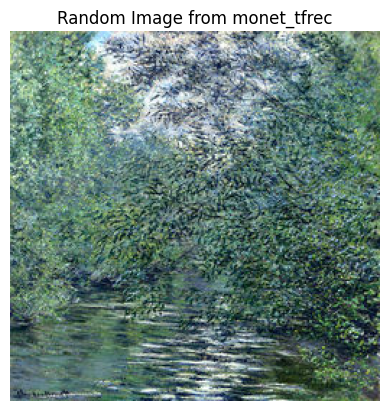

In [7]:
random_image_from_tfrecord("/kaggle/input/gan-getting-started/monet_tfrec/")

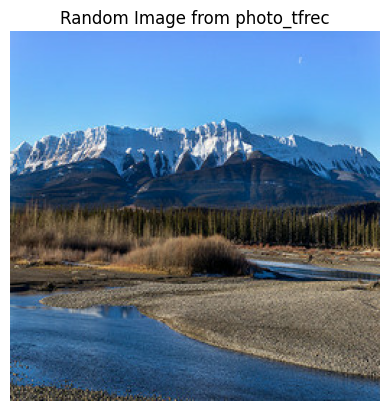

In [8]:
random_image_from_tfrecord("/kaggle/input/gan-getting-started/photo_tfrec/")

In the above code blocks, I wrote a function to randomly choose an image from the tfrecord files and display it. I ran this a few times to get a sense of the types of images I'm working with.

I also had the values in the image divided by 255, so they should be scaled to [0, 1], but I'll verify that with a histogram of color values for an image.

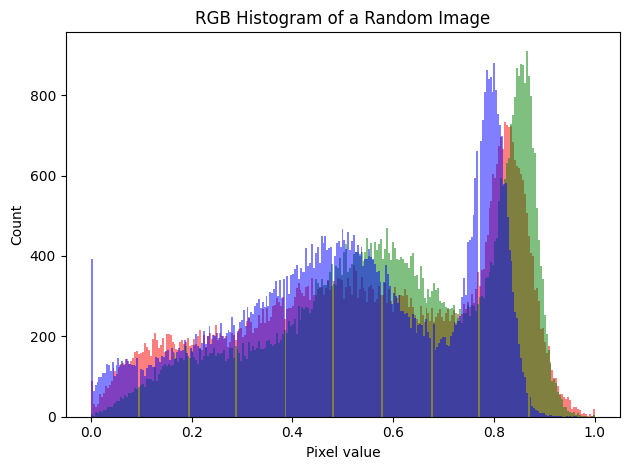

In [9]:
# Choose a random tfrecord file
directory = "/kaggle/input/gan-getting-started/monet_tfrec/"
tfrecord_files = tf.io.gfile.glob(os.path.join(directory, '*.tfrec'))
random_file = random.choice(tfrecord_files)

# Open up the tfrecord file
raw_dataset = tf.data.TFRecordDataset(random_file)

# Function to unpack images from the opened tfrecord file
def parse_image(record):
    feature_description = {'image': tf.io.FixedLenFeature([], tf.string)}
    parsed = tf.io.parse_single_example(record, feature_description)
    image = tf.io.decode_jpeg(parsed['image'], channels=3)
    image = tf.image.resize(image, [256, 256])
    image = tf.cast(image, tf.float32) / 255.0  # [0, 1] range for display
    return image

# Parse the dataset
parsed_dataset = raw_dataset.map(parse_image)

# Grab the image
image = next(iter(parsed_dataset.take(1)))
image_np = image.numpy()

# Plot histogram
colors = ['red', 'green', 'blue']

for i, color in enumerate(colors):
    plt.hist(image_np[:, :, i].ravel(), bins=256, color=color, alpha=0.5, label=color.upper())

plt.title('RGB Histogram of a Random Image')
plt.xlabel('Pixel value')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

Looks like all of the data is between 0 and 1 after I transformed it, as expected.

These images look clean and ready for training, especially since they cam prepackaged in tfrec files. In the next section, I'll build GANs and use these images to train and validate them.

### Model Architecture

Parts of this section, including the CycleGAN implementation, are inspired by the [Monet CycleGAN Tutorial](https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial) notebook provided in the Kaggle challenge.

CycleGAN is a type of Generative Adversarial Network (GAN) specifically designed for unpaired image-to-image translation—for example, transforming photos into Monet-style paintings without having a direct 1-to-1 mapping between the images.

The architecture consists of:

Two Generators:

Generator G: Transforms real photos into Monet-style images.

Generator F: Transforms Monet-style images back into real photos.

Two Discriminators:

Discriminator X: Distinguishes between real photos and generated (fake) photos.

Discriminator Y: Distinguishes between real Monet paintings and generated Monet-style images.

The generators learn to produce increasingly realistic outputs, while the discriminators improve their ability to detect fake images. This adversarial dynamic pushes the network to produce high-quality, stylized results.

I implemented a CycleGAN class that extends the tf.keras.Model class. This custom model manages the generators and discriminators, computes cycle-consistency and adversarial losses, and applies the appropriate gradients during training.



In [ ]:
# Define a custom CycleGAN model class using Keras Model subclassing
class CycleGAN(tf.keras.Model):
    def __init__(self, generator_g, generator_f, discriminator_x, discriminator_y):
        super(CycleGAN, self).__init__()
        # generator_g: Photo -> Monet
        # generator_f: Monet -> Photo
        self.generator_g = generator_g
        self.generator_f = generator_f
        self.discriminator_x = discriminator_x  # Discriminator for domain X (Photos)
        self.discriminator_y = discriminator_y  # Discriminator for domain Y (Monet)

    def compile(self, generator_optimizer, discriminator_optimizer, loss_fn):
        super(CycleGAN, self).compile()
        # Optimizers and loss function for both generator and discriminator
        self.generator_optimizer = generator_optimizer
        self.discriminator_optimizer = discriminator_optimizer
        self.loss_fn = loss_fn

    def train_step(self, batch_data):
        # Unpack the batch into real examples from both domains
        real_x, real_y = batch_data

        # Use persistent tape to calculate gradients for both networks
        with tf.GradientTape(persistent=True) as tape:
            # Forward pass: Generate fake images
            fake_y = self.generator_g(real_x)  # Translate photo to Monet
            fake_x = self.generator_f(real_y)  # Translate Monet to photo

            # Discriminator predictions on real and fake images
            disc_real_x = self.discriminator_x(real_x)
            disc_fake_x = self.discriminator_x(fake_x)

            disc_real_y = self.discriminator_y(real_y)
            disc_fake_y = self.discriminator_y(fake_y)

            # Discriminator loss for each domain
            loss_d_x = self.loss_fn(disc_real_x, disc_fake_x)
            loss_d_y = self.loss_fn(disc_real_y, disc_fake_y)

            # Generator adversarial losses (how well they fool the discriminators)
            loss_g_x = self.loss_fn(disc_fake_x, disc_real_x)
            loss_g_y = self.loss_fn(disc_fake_y, disc_real_y)

            # Cycle consistency losses
            cycle_loss_x = tf.reduce_mean(tf.abs(real_x - self.generator_f(fake_y)))  # Reconstruct photo
            cycle_loss_y = tf.reduce_mean(tf.abs(real_y - self.generator_g(fake_x)))  # Reconstruct Monet

            # Total combined loss
            total_loss = loss_g_x + loss_g_y + cycle_loss_x + cycle_loss_y + loss_d_x + loss_d_y

        # Compute gradients for generators and discriminators
        generator_gradients = tape.gradient(total_loss, 
            self.generator_g.trainable_variables + self.generator_f.trainable_variables)
        discriminator_gradients = tape.gradient(total_loss, 
            self.discriminator_x.trainable_variables + self.discriminator_y.trainable_variables)

        # Apply gradients to update weights
        self.generator_optimizer.apply_gradients(zip(generator_gradients, 
            self.generator_g.trainable_variables + self.generator_f.trainable_variables))
        self.discriminator_optimizer.apply_gradients(zip(discriminator_gradients, 
            self.discriminator_x.trainable_variables + self.discriminator_y.trainable_variables))

        # Return loss as training metric
        return {"total_loss": total_loss}

    # Inference call - translates an image from domain X (photo) to domain Y (Monet)
    def call(self, inputs):
        return self.generator_g(inputs)


The above CycleGAN class will be trained with the photos that we've been provided for this challenge. Therefore, the next step is to bring the images into the notebook:

In [ ]:
# Set the desired image size for all images
IMAGE_SIZE = [256, 256]

# Function to decode JPEG-encoded image bytes to a float32 tensor scaled to [-1, 1]
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)  # Decode JPEG image to RGB
    image = (tf.cast(image, tf.float32) / 127.5) - 1  # Normalize to [-1, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3])       # Resize image to fixed shape
    return image

# Function to parse a single TFRecord example
def read_tfrecord(example):
    # Define the format of the TFRecord file
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),  # Not used but present
        "image": tf.io.FixedLenFeature([], tf.string),       # Encoded image
        "target": tf.io.FixedLenFeature([], tf.string)       # Not used here
    }
    example = tf.io.parse_single_example(example, tfrecord_format)  # Parse the example
    image = decode_image(example['image'])  # Decode and preprocess the image
    return image

# Function to load a TFRecord dataset
def load_dataset(filenames, labeled=True, ordered=False):
    # Create a TFRecordDataset from the list of filenames
    dataset = tf.data.TFRecordDataset(filenames)
    
    # Apply the parsing function to each example
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    
    # Return the dataset of decoded and normalized images
    return dataset


With the functions above, I'll be able to read in the images from the .tfrec files that come with this Kaggle challenge. In the next code block, I'll bring in the image data:

In [ ]:
# Enable automatic tuning of performance parameters for the dataset pipeline
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Get the GCS (Google Cloud Storage) path to the Kaggle dataset
GCS_PATH = KaggleDatasets().get_gcs_path()

# Get all TFRecord file paths for Monet-style images
MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))

# Get all TFRecord file paths for real photographs
PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))

# Load the Monet TFRecord dataset, decode and batch the data (1 image per batch)
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)

# Load the photo TFRecord dataset, decode and batch the data (1 image per batch)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

I also need to provide the CycleGAN with the architecture for the generator and discriminator. We learned earlier in this course that convolutional layers are particularly well suited for training with image data, so I leverged those in both the generator and discriminator. Since training on image data can be time consuming, I chose to keep the architecture simple, and use 2 convolutional layers.

In [ ]:
# Function to build the generator model
def build_generator():
    # Define a simple sequential model
    model = tf.keras.Sequential([
        # Input layer for 256x256 RGB image
        layers.InputLayer(input_shape=(256, 256, 3)),

        # Convolution layer to extract features with 64 filters of size 3x3 and ReLU activation
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),

        # Output convolution layer with 3 filters (RGB), tanh activation to produce final image
        # Tanh activation scales the output to [-1, 1] for consistency with preprocessing
        layers.Conv2D(3, (3, 3), activation='tanh', padding='same')
    ])
    return model

# Function to build the discriminator model
def build_discriminator():
    # Define a simple sequential model
    model = tf.keras.Sequential([
        # Input layer for 256x256 RGB image
        layers.InputLayer(input_shape=(256, 256, 3)),

        # Convolution layer to extract features, output is a lower-dimensional feature map
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),

        # Output layer with a single filter and sigmoid activation to classify as real/fake
        # Each pixel indicates whether the patch is real (1) or fake (0)
        layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')
    ])
    return model


In the next code block, I instaniate the discriminators, generators, and cycleGAN. I chose to go with the Adam optimizer, since it was emphasized in the lectures that this is a great optimizer to begin with. Then, I compiled the model, so it is ready to begin training.

In [ ]:
# Build the generator models
# generator_g: Converts photos to Monet-style paintings
# generator_f: Converts Monet-style paintings back to photos
generator_g = build_generator()
generator_f = build_generator()

# Build the discriminator models
# discriminator_x: Tries to distinguish real photos from generated (fake) photos
# discriminator_y: Tries to distinguish real Monet paintings from generated Monet-style images
discriminator_x = build_discriminator()
discriminator_y = build_discriminator()

# Initialize the CycleGAN model with the generators and discriminators
cyclegan = CycleGAN(generator_g, generator_f, discriminator_x, discriminator_y)

# Optimizers for training the generators and discriminators
# Adam is commonly used for GANs, with a low learning rate and beta_1=0.5 for stability
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)

# Binary cross-entropy loss function
# Used to compare real vs. fake predictions from the discriminators
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)

# Compile the CycleGAN model with the optimizers and loss function
cyclegan.compile(generator_optimizer, discriminator_optimizer, loss_fn)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Now, we're ready to begin training. I'll package the data together, provide it to the model. I set the number of epochs to 10.

In [16]:
paired_ds = tf.data.Dataset.zip((monet_ds, photo_ds))

cyclegan.fit(paired_ds, epochs=10)

Epoch 1/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 457s 1s/step - total_loss: 1.6031
Epoch 2/10


/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


300/300 ━━━━━━━━━━━━━━━━━━━━ 453s 2s/step - total_loss: 0.3371
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 452s 2s/step - total_loss: 0.2072
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 452s 2s/step - total_loss: 0.1656
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 455s 2s/step - total_loss: 0.1449
Epoch 6/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 455s 2s/step - total_loss: 0.1286
Epoch 7/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 454s 2s/step - total_loss: 0.1148
Epoch 8/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 456s 2s/step - total_loss: 0.1050
Epoch 9/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 455s 2s/step - total_loss: 0.0980
Epoch 10/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 457s 2s/step - total_loss: 0.0925


The model has now been trained. Looking closely at the output shows that training was fairly time consuming, taking about 7 to 8 minutes to complete each epoch. After 10 epochs, that's over 1 hour to complete training. Kaggle's GPU and TPU resources are limited to 30 hours a week, so I had to complete this with a CPU. This contributed to the lengthy training process.

In the next section, I'll review model output and make a submission to the Kaggle challenge.

### Results and Analysis

I'm very curious to see how the model performed. I should be able to give the model a photograph, and it will turn it into something that looks like a Monet painting. In the following code block, I will get five photographs and see how the model transforms them:

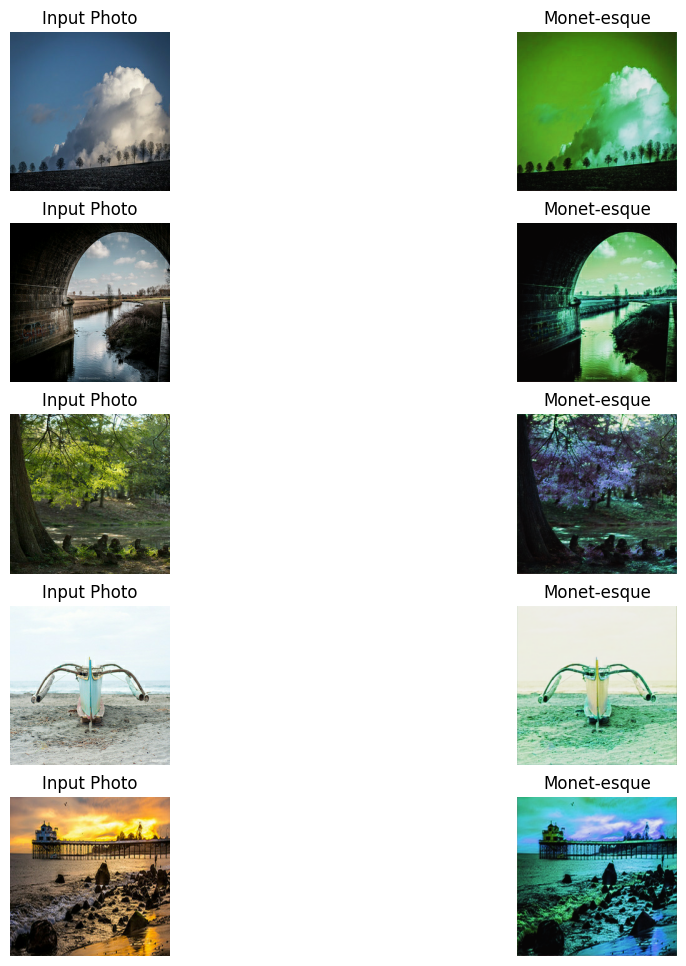

In [22]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = generator_g(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

Recall that we used a fairly simple, two-layer convolutional neural network for the generators and discriminators. The output from the models are certainly transformations of the input photos. I would say that the color resemble the colors you would expect to see in a Monet painting, with heightened saturation. However, I think a future iteration of this project could improve the model so that brushstroke are more visible, and the structure of the image is more painting-like. However, I think the color transformation is impressive.

Now, I'll submit this model to the Kaggle challenge. Since this submission requires images, it's a bit more complicated than a tradition Kaggle challenge, which is often just a .csv submission. First, I want to make a folder for the images that will be generated.

In [38]:
import PIL
! mkdir images

For every photo in the dataset, I want the model to output it's transformed version of the photo.

In [ ]:
i = 1  # Initialize an image counter

# Loop over each image in the dataset `photo_ds`
for img in photo_ds:
    
    # Generate a prediction using the generator model (e.g., a GAN or image translator)
    # `training=False` ensures inference mode (no dropout, batch norm updates, etc.)
    prediction = generator_g(img, training=False)[0].numpy()
    
    # Rescale the pixel values from [-1, 1] range back to [0, 255]
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    
    # Convert the NumPy array to a PIL image
    im = PIL.Image.fromarray(prediction)
    
    # Save the image to the specified directory with a sequential file name
    im.save("/kaggle/working/images/" + str(i) + ".jpg")
    
    # Increment the image counter
    i += 1


I'll zip up those images and name the zip file "images.zip" (as required).

In [34]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/working/images")

'/kaggle/working/images.zip'

Finally, remove the non-zipped version of the images, since they're no longer needed.

In [39]:
shutil.rmtree("/kaggle/working/images")

From here, I used the interface in the Kaggle notebook to make the submission!

### Conclusion

I learned that Generative Adversarial Networks (GANs) can accomplish some amazing tasks. The model I built was able to take an image, examine it's parts, bring it back together, and produce a transformed image in a different style. With that, I'll reflect on a few takeaways from this project:

Here's what helped improve the performance of my models:
 * The generator/discriminator architecture is not something I've seen before, but this design obviously allowed the model to apply some amazing transformations to the images.
 * Using convolutional layers in the discriminator and generator was important, especially since the model was training on image data
 * The data was normalized to the range [-1, 1], which helped stabilize training and improve the model's performance

Here's what didn't help improve the performance of my models (and some lessons learned):
 * I would want to spend more time tuning the number of epochs, because I think 10 may not have been enough. More epochs might give the model more time to converge and produce better results
 * The architecture I built for the generator and discriminator were simple, and produced interesting results, but could probably be improved further by adding more layers, or by using a pre-trained model.

Here's what I'd like to try in the future:
 * In the future, I'd like to have more access to GPUs or TPUs to train GANs. These models can produce some amazing results, but are certainly the most resource-intensive models we worked with in this course.
 * Given some additional resources, I think it would be really cool to provide my own images to the model and see what it's able to transform them into.
 * I'd also like to have more of a chance to tweak the learning rate and see how it affects training. With amount of time it took to train the model, I did not get to try many different learning rates.